<a href="https://colab.research.google.com/github/PashaIanko/CIFAR10Recognition/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [28]:
# Pytorch functions
import torch
import tensorflow
# Neural network layers
import torch.nn as nn
import torch.nn.functional as F
# Optimizer
import torch.optim as optim
# Handling dataset
import torch.utils.data as data
# Torchvision library
import torchvision

import matplotlib.pyplot as plt
import random
import numpy as np
import copy
import time
import os
import cv2
# For results
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
from sklearn.model_selection import train_test_split

# Helper functions

In [16]:
def plot_history(history_):
    _, ax = plt.subplots(1, 2)
    ax[0].plot(history_.history['accuracy'], label='train')
    ax[0].plot(history_.history['val_accuracy'], label='val')

    ax[1].plot(history_.history['loss'], label='train')
    ax[1].plot(history_.history['val_loss'], label='val')

    ax[0].legend()
    ax[1].legend()

In [17]:
def check_labels(y_arrs_):
    for y_arr in y_arrs_:
        assert len(np.unique(y_arr)) == 10

def print_shapes(arrs_):
    for arr in arrs_:
        print(arr.shape)

In [18]:
def check_data(arrs_):
    for arr in arrs_:
        assert np.min(arr) >= -3 and np.max(arr) <= 3

In [19]:
def report(arrs_):
    for arr_ in arrs_:
        print(np.min(arr_), np.max(arr_))

In [20]:
# def set_seed(seed, use_gpu = True):
#     """
#     Set SEED for PyTorch reproducibility
#     """
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     if use_gpu:
#         torch.cuda.manual_seed_all(seed)
#         torch.cuda.manual_seed(seed)
#         torch.backends.cudnn.deterministic = True
#         torch.backends.cudnn.benchmark = False

# SEED = 44

# USE_SEED = True

# if USE_SEED:
#     set_seed(SEED, torch.cuda.is_available())

In [21]:
def get_subsample(X_, Y_, percentage_):
    X_sub, _, Y_sub, _ = \
        train_test_split(
            X_,
            Y_,
            train_size=percentage_,
            random_state=42,
            stratify=Y_
        )
    return X_sub, Y_sub

In [22]:
def flatten(arr_):
    assert len(arr_.shape) == 4
    return arr_.reshape(
        arr_.shape[0],
        arr_.shape[1] * arr_.shape[2] * arr_.shape[3]
    )


def reshape_back_to_images(arr_):
    return arr_.reshape(arr_.shape[0], 32, 32, 3)

# Download the data

In [23]:
ROOT = './data'
train_data = torchvision.datasets.CIFAR10(
    root=ROOT,
    train=True,
    download=True
)

Files already downloaded and verified


In [24]:
test_data = torchvision.datasets.CIFAR10(
    root=ROOT,
    train=False,
    download=True,
    # transform=test_transforms
)

Files already downloaded and verified


In [25]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [26]:
train_data.data.shape, type(train_data.data)

((50000, 32, 32, 3), numpy.ndarray)

In [27]:
test_data.data.shape

(10000, 32, 32, 3)

# Data exploration

Text(0.5, 1.0, 'Label: truck')

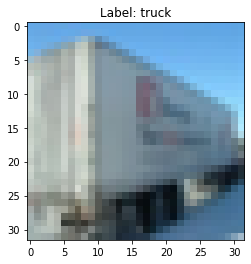

In [ ]:
img_idx = 15
_, ax = plt.subplots()

img = train_data[img_idx][0]
label = train_data[img_idx][1]
ax.imshow(img)

ax.set_title(
    f'Label: {classes[label]}'
)

In [ ]:
np.min(train_data.data), np.max(train_data.data)

(0, 255)

In [ ]:
train_mean = train_data.data.mean(axis=(0,1,2)) / 255
train_std = train_data.data.std(axis=(0,1,2)) / 255

print("-----  TRAIN NORMALIZATION VALUES  -----")
print(f"Mean: {train_mean}")
print(f"Standard Deviation: {train_std}")

-----  TRAIN NORMALIZATION VALUES  -----
Mean: [0.49139968 0.48215841 0.44653091]
Standard Deviation: [0.24703223 0.24348513 0.26158784]


# Data split

In [15]:
TRAIN_PERCENTAGE = 0.9
VAL_PERCENTAGE = 0.1
RANDOM_STATE = 42
assert TRAIN_PERCENTAGE + VAL_PERCENTAGE == 1.0

In [16]:
train_labels = np.array([train_data[i][1] for i in range(len(train_data))])

In [17]:
assert len(np.unique(train_labels)) == 10
train_labels.shape, train_data.data.shape

((50000,), (50000, 32, 32, 3))

In [18]:
X_test = test_data.data
Y_test = np.array([test_data[i][1] for i in range(len(test_data))])
Y_test.shape, X_test.shape

((10000,), (10000, 32, 32, 3))

In [19]:
X_train, X_validation, Y_train, Y_validation = \
    train_test_split(
        train_data.data,
        train_labels,
        train_size=TRAIN_PERCENTAGE,
        random_state=42,
        stratify=train_labels
    )

In [20]:
X_train.shape, X_validation.shape, Y_train.shape, Y_validation.shape

((45000, 32, 32, 3), (5000, 32, 32, 3), (45000,), (5000,))

# Data preprocessing

In [38]:
from sklearn.preprocessing import StandardScaler

In [39]:
scaler = StandardScaler()

In [40]:
X_train = reshape_back_to_images(
    scaler.fit_transform(flatten(X_train)))

X_validation = reshape_back_to_images(
    scaler.transform(flatten(X_validation)))

X_test = reshape_back_to_images(
    scaler.transform(flatten(X_test)))

In [41]:
check_data([X_train, X_validation, X_test])
check_labels([Y_train, Y_validation, Y_test])
print_shapes([X_train, X_validation, X_test])

(45000, 32, 32, 3)
(5000, 32, 32, 3)
(10000, 32, 32, 3)


In [42]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
Y_train = encoder.fit_transform(Y_train.reshape(-1, 1)).toarray()
Y_validation = encoder.transform(Y_validation.reshape(-1, 1)).toarray()
Y_test = encoder.transform(Y_test.reshape(-1, 1)).toarray()

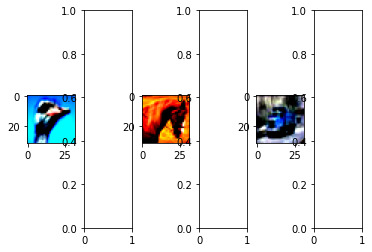

In [43]:
idx = 172
_, ax = plt.subplots(1, 6)
ax[0].imshow(X_train[idx])
# ax[1].imshow(train_data[idx][0])

ax[2].imshow(X_validation[idx])
#ax[3].imshow(X_validation_scaled[idx])

ax[4].imshow(X_test[idx])
# ax[5].imshow(X_test_scaled[idx])

In [44]:
SUBSAMPLE_PERCENTAGE = 0.3

X_train_subsample, _, Y_train_subsample, _ = \
    train_test_split(
        X_train,
        Y_train,
        random_state=42,
        train_size=SUBSAMPLE_PERCENTAGE,
        stratify=Y_train
    )

In [45]:
X_validation_subsample, _, Y_validation_subsample, _ = \
    train_test_split(
        X_validation,
        Y_validation,
        random_state=42,
        train_size=SUBSAMPLE_PERCENTAGE,
        stratify=Y_validation
    )

In [46]:
print_shapes(
    [
        X_train,
        X_train_subsample,
        X_validation,
        X_validation_subsample
    ]
)

check_data([X_train, X_train_subsample, X_validation, X_validation_subsample])

(45000, 32, 32, 3)
(13500, 32, 32, 3)
(5000, 32, 32, 3)
(1500, 32, 32, 3)


# Baseline

In [38]:
from tensorflow.keras.models import Sequential

In [39]:
from tensorflow.keras.layers import (
    Input,
    Dense,
    Conv2D,
    MaxPool2D,
    Dropout,
    BatchNormalization,
    Flatten
)
from functools import partial

In [40]:
conv_layer = partial(
    Conv2D,
    activation='relu',
    kernel_initializer='he_normal',
    kernel_size=(3, 3)
)

In [41]:
baseline_cnn = Sequential(
    [
        Input(shape=(32, 32, 3)),

        conv_layer(filters=32),
        conv_layer(filters=64),
        MaxPool2D(pool_size=(2, 2)),
     
        conv_layer(filters=128),
        MaxPool2D(pool_size=(2, 2)),
     
        conv_layer(filters=256),
        conv_layer(filters=256),
        MaxPool2D(pool_size=(2, 2)),
     
        Flatten(),
        # Dropout(0.2),
        Dense(300, activation='relu', kernel_initializer='he_normal'),
        Dropout(0.2),
        Dense(100, activation='relu', kernel_initializer='he_normal'),
        Dropout(0.2),
        Dense(10, activation='softmax')
    ]
)

In [45]:
baseline_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [46]:
print_shapes(
    [
        X_train_subsample,
        Y_train_subsample,
        X_validation_subsample,
        Y_validation_subsample
    ]
)

(13500, 32, 32, 3)
(13500, 10)
(1500, 32, 32, 3)
(1500, 10)


In [47]:
from tensorflow.keras.callbacks import EarlyStopping

history = baseline_cnn.fit(
    X_train_subsample,
    Y_train_subsample,
    validation_data=(X_validation_subsample, Y_validation_subsample),
    epochs=20,
    batch_size=32,
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            mode='min',
            patience=3
        )
    ]
)

Epoch 1/20
422/422 [==============================] - 123s 289ms/step - loss: 1.9273 - accuracy: 0.2864 - val_loss: 1.4985 - val_accuracy: 0.4393
Epoch 2/20
422/422 [==============================] - 159s 377ms/step - loss: 1.4738 - accuracy: 0.4496 - val_loss: 1.3033 - val_accuracy: 0.5407
Epoch 3/20
422/422 [==============================] - 146s 345ms/step - loss: 1.2355 - accuracy: 0.5576 - val_loss: 1.1767 - val_accuracy: 0.5773
Epoch 4/20
422/422 [==============================] - 163s 386ms/step - loss: 1.0495 - accuracy: 0.6304 - val_loss: 1.0604 - val_accuracy: 0.6247
Epoch 5/20
422/422 [==============================] - 176s 418ms/step - loss: 0.8719 - accuracy: 0.6940 - val_loss: 1.0357 - val_accuracy: 0.6447
Epoch 6/20
422/422 [==============================] - 125s 296ms/step - loss: 0.7014 - accuracy: 0.7518 - val_loss: 1.0684 - val_accuracy: 0.6507
Epoch 7/20
422/422 [==============================] - 160s 380ms/step - loss: 0.5599 - accuracy: 0.8070 - val_loss: 1.1127 -

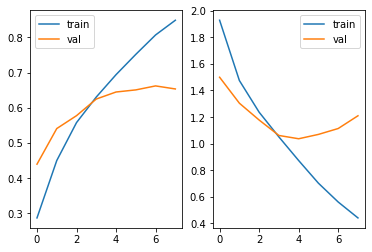

In [50]:
plot_history(history)

In [52]:
baseline_cnn.evaluate(
    X_validation,
    Y_validation
)

157/157 [==============================] - 9s 58ms/step - loss: 1.1862 - accuracy: 0.6554


[1.1862057447433472, 0.6553999781608582]

In [53]:
baseline_cnn.evaluate(
    X_train,
    Y_train
)

 239/1407 [====>.........................] - ETA: 1:03 - loss: 0.9558 - accuracy: 0.7210

KeyboardInterrupt: ignored

# ResNet50 transfer learning

In [42]:
ROOT = './data'
train_data = torchvision.datasets.CIFAR10(
    root=ROOT,
    train=True,
    download=True
)

Files already downloaded and verified


In [43]:
test_data = torchvision.datasets.CIFAR10(
    root=ROOT,
    train=False,
    download=True,
    # transform=test_transforms
)

Files already downloaded and verified


In [44]:
training_images = train_data.data
training_labels = np.array([train_data[i][1] for i in range(len(train_data))])

test_images = test_data.data
test_labels = np.array([test_data[i][1] for i in range(len(test_data))])

In [45]:
X_train_resnet, X_validation_resnet, Y_train_resnet, Y_validation_resnet = \
    train_test_split(
        training_images,
        training_labels,
        train_size=0.9,
        random_state=42,
        stratify=training_labels
    )

print_shapes(
    [
        X_train_resnet,
        X_validation_resnet,
        Y_train_resnet,
        Y_validation_resnet
    ]
)

(45000, 32, 32, 3)
(5000, 32, 32, 3)
(45000,)


In [29]:
# (training_images, training_labels), (validation_images, validation_labels) = \
#     tensorflow.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 6s 0us/step


In [46]:
def preprocess_image_input(input_images):
    input_images = input_images.astype('float32')
    output_ims = tensorflow.keras.applications.resnet50.preprocess_input(input_images)
    return output_ims

In [31]:
# train_X = preprocess_image_input(training_images)
# valid_X = preprocess_image_input(validation_images)

In [47]:
X_train_resnet = preprocess_image_input(X_train_resnet)
X_validation_resnet = preprocess_image_input(X_validation_resnet)
X_test_resnet = preprocess_image_input(test_images)

In [48]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    Dropout,
    Input,
    UpSampling2D,
    GlobalAveragePooling2D
)
import tensorflow as tf
from tensorflow.keras.models import Sequential

model = Sequential()

model.add(Input(shape=(32, 32, 3)))
model.add(UpSampling2D(size=(7, 7)))
model.add(ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
))

model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [49]:
model.compile(
    optimizer='SGD',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [50]:
SUBSAMPLE_PERCENTAGE = 0.3

X_train_subsample, _, Y_train_subsample, _, = \
    train_test_split(
        X_train_resnet, # train_X,
        Y_train_resnet, # training_labels,
        train_size=SUBSAMPLE_PERCENTAGE,
        random_state=42,
        stratify=Y_train_resnet, # stratify=training_labels
    )

X_validation_subsample, _, Y_validation_subsample, _ = \
    train_test_split(
        X_validation_resnet, # valid_X,
        Y_validation_resnet, #validation_labels,
        train_size=SUBSAMPLE_PERCENTAGE,
        random_state=42,
        stratify=Y_validation_resnet  # stratify=validation_labels
    )

In [51]:
history = model.fit(
    X_train_subsample,
    Y_train_subsample,
    epochs=3,
    validation_data=(X_validation_subsample, Y_validation_subsample),
    batch_size=64
)

Epoch 1/3
211/211 [==============================] - 143s 656ms/step - loss: 0.7973 - accuracy: 0.7501 - val_loss: 0.4298 - val_accuracy: 0.8540
Epoch 2/3
211/211 [==============================] - 138s 654ms/step - loss: 0.2081 - accuracy: 0.9356 - val_loss: 0.3133 - val_accuracy: 0.8973
Epoch 3/3
211/211 [==============================] - 138s 655ms/step - loss: 0.0705 - accuracy: 0.9821 - val_loss: 0.2791 - val_accuracy: 0.9133


In [34]:
# history = model.fit(
#     train_X,
#     training_labels,
#     epochs=3,
#     validation_data=(valid_X, validation_labels),
#     batch_size=64
# )

Epoch 1/3
134/782 [====>.........................] - ETA: 6:26 - loss: 1.0315 - accuracy: 0.6733

KeyboardInterrupt: ignored

# From other source resnet

In [15]:
import tensorflow

In [16]:
(training_images, training_labels), (validation_images, validation_labels) = \
    tensorflow.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [17]:
training_images.shape

(50000, 32, 32, 3)

In [26]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tensorflow.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims

In [27]:
report([training_images, validation_images])


0 255
0 255


In [28]:
train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

In [29]:
report([train_X, valid_X])

-123.68 151.061
-123.68 151.061


In [64]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import (
    Dense,
    Dropout
)
import tensorflow as tf
from tensorflow.keras.models import Sequential

def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor


def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


model = define_compile_model()


In [65]:
history = model.fit(
    train_X,
    training_labels,
    epochs=3,
    validation_data=(valid_X, validation_labels),
    batch_size=64
)

Epoch 1/3
167/782 [=====>........................] - ETA: 6:45 - loss: 0.8920 - accuracy: 0.7178

KeyboardInterrupt: ignored

# Plans
- Full dataset
- ResNet
- Data augmentation
- Hyperparameter fine-tuning
- Pretrained networks